# Coursera Capstone Project- Relationship between crime and the type of businesses in an area. 

## Introduction 
This notebook is part of the IBM data science capstone project. In this project we will be using data from the foursquare api as well as official crime data from government websites to see relationships between the type of businesses in an area and there effect on the crime rate. This can be used to get some insights on the factors that lead to crime and why certain neighborhoods can have lower crime rates based on the businesses that are running in that area. This data study can be of interest to local authorities to have a way to predict the impacts a new business might have on the surrounding area. Additionally, this data can be of interest to anyone looking to startup a business as they look for the best location to start at. 

## The data :
### 1. Foursquare API venue data :
Foursquare is the leading API for location and venue data, the credentials obtained from creating a developer account will allow for the API to be queryed for information on the businesses in certain neighbourhoods. 
### 2. San Fransico crime data :
Detailed records on the crime in San Fransico will be used to find the neighbouhoods with the highest crime rates and try and find a correlation between the type of business and the type/ frequency of crimes that happen in an area. 
### 3. San Fransisco Registered Business Data: 
This will help us determine the footfall in each neighborhood which may be a factor in a crime taking place. 

### Gathering the data: 

The first step is to import all the necessary libraries: 

In [1]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

     |████████████████████████████████| 98 kB 7.7 MB/s  eta 0:00:01
     |████████████████████████████████| 93 kB 3.6 MB/s  eta 0:00:01
All libraries imported.


Next, we define all the necessary foursquare credentials obtained from creating a developer account : 

In [2]:
CLIENT_ID = 'NMG2N4DJCM4FVWQB2DNNNCVKHH51MSZEGYRPSHOAEVOGU1I4' # Foursquare ID
CLIENT_SECRET = 'OI40DTVPSJZO0ALBQRMXOACDBBNTD3WCTLAT4YFCKXJQAXRL' # Foursquare Secret
ACCESS_TOKEN = 'CZ4RHS5NTXHEDBIDB1A4B2FMRXX4WMJ5NNFEBPJQXKWUS4PW' # FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NMG2N4DJCM4FVWQB2DNNNCVKHH51MSZEGYRPSHOAEVOGU1I4
CLIENT_SECRET:OI40DTVPSJZO0ALBQRMXOACDBBNTD3WCTLAT4YFCKXJQAXRL


## Crime data 

In [3]:
crime = pd.read_csv('https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD')
print(crime.shape)
crime.head()

(418994, 36)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites),ESNCAG - Boundary File,"Areas of Vulnerability, 2016"
0,2018/01/01 09:26:00 AM,2018/01/01,09:26,2018,Monday,2018/01/01 09:27:00 AM,61893007041,618930,171052174,173641140.0,...,88.0,2.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0
1,2018/01/01 02:30:00 AM,2018/01/01,02:30,2018,Monday,2018/01/01 08:21:00 AM,61893105041,618931,180000768,180010668.0,...,90.0,9.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,2.0
2,2018/01/01 10:00:00 AM,2018/01/01,10:00,2018,Monday,2018/01/01 10:20:00 AM,61893275000,618932,180000605,180010893.0,...,20.0,4.0,10.0,36.0,NaN,NaN,1.0,NaN,NaN,2.0
3,2018/01/01 10:03:00 AM,2018/01/01,10:03,2018,Monday,2018/01/01 10:04:00 AM,61893565015,618935,180000887,180011579.0,...,NaN,9.0,1.0,28.0,NaN,NaN,NaN,NaN,NaN,1.0
4,2018/01/01 09:01:00 AM,2018/01/01,09:01,2018,Monday,2018/01/01 09:39:00 AM,61893607041,618936,171052958,180011403.0,...,106.0,6.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,2.0


In [4]:

#take just the columns we need
crime1 = crime[['Analysis Neighborhood','Incident Category', 'Incident Date']]

#drop all null values
crime2 = crime1.dropna()



# convert the data type of the incident date column to date/time
pd.options.mode.chained_assignment = None  # default='warn'
crime2['Incident Date']= pd.to_datetime(crime2['Incident Date'])

# filter out all crimes that happened befor 2017 to be as accurate as possible with recent data
crime3 = crime2.loc[crime2['Incident Date'] > '2017-01-01']

# rename column headings to more intuitive ones 
crime3.rename(columns={'Analysis Neighborhood':'Neighborhood',
                          'Incident Category':'Incident_type',
                          'Incident Date':'Date'}, 
                 inplace=True)


crime3.head()


,Neighborhood,Incident_type,Date
0,Bayview Hunters Point,Recovered Vehicle,2018-01-01
1,Excelsior,Burglary,2018-01-01
2,Tenderloin,Missing Person,2018-01-01
3,Outer Mission,Other Miscellaneous,2018-01-01
4,Chinatown,Recovered Vehicle,2018-01-01


In [5]:
## now we can group the neighbourhoods by the number of incidents 
crime4 = crime3.groupby('Neighborhood', as_index=False).count()
crime4.head()

# get rid of the incedent date column 
crime4.drop(columns = 'Date',inplace = True)

# sort the data to be more readable in a plot 
crime5 = crime4.sort_values(by= ['Incident_type'], ascending = False)

crime6= crime5.head(10)

crime6

,Neighborhood,Incident_type
18,Mission,44423
35,Tenderloin,41121
5,Financial District/South Beach,34398
33,South of Market,33867
0,Bayview Hunters Point,24424
40,Western Addition,13036
2,Castro/Upper Market,12292
22,North Beach,11922
34,Sunset/Parkside,11805
20,Nob Hill,11541


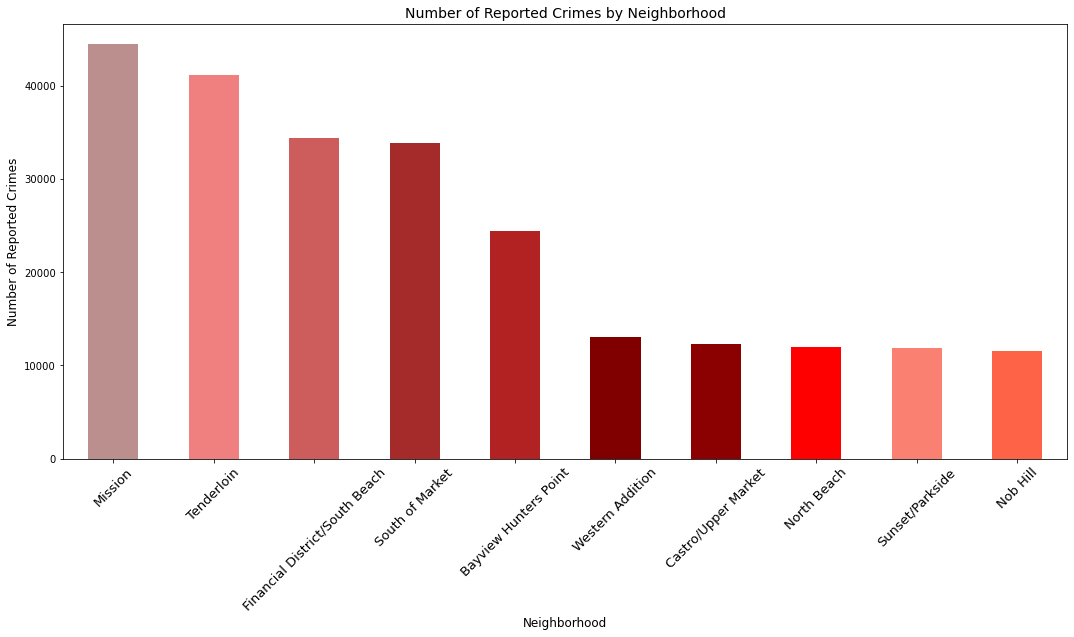

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

crime6.plot.bar(x = 'Neighborhood', y = 'Incident_type', title = "Crime Incidents by Neighborhood", legend = None, rot= 45, figsize = (18, 8), color=['rosybrown', 'lightcoral', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'salmon', 'tomato'])
plt.ylabel('Number of Reported Crimes', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Neighborhood', fontsize=12)
plt.title('Number of Reported Crimes by Neighborhood', fontsize = 14)
plt.show()

The figure above shows that the top 5 neighborhoods are by far the ones with the most crime.  
Further investigation can be done to try and find a reason for this. 

## Foursqaure Data: 

Befor we can use the Foursquare API we need to gather the Latitude and Longitude Coordinates for each of our Neighbourhoods. This is done as follows: 

In [8]:

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SF_explorer")
crime6['Coordinates'] = crime6['Neighborhood'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
crime6


,Neighborhood,Incident_type,Coordinates
18,Mission,44423,"(26.2159066, -98.3252932)"
35,Tenderloin,41121,"(37.7842493, -122.4139933)"
5,Financial District/South Beach,34398,"(42.3511706, -71.059665)"
33,South of Market,33867,"(37.7808925, -122.4009518)"
0,Bayview Hunters Point,24424,"(46.823038, -92.0821832)"
40,Western Addition,13036,"(37.779559, -122.4298104)"
2,Castro/Upper Market,12292,"(37.767115, -122.4288861)"
22,North Beach,11922,"(37.8011749, -122.4090021)"
34,Sunset/Parkside,11805,"(42.75562315, -81.19147418031011)"
20,Nob Hill,11541,"(22.34154935, 114.1370988538701)"


Next we can split the coordinates column into Latitude and Longitude and then drop the coordinates column:

In [9]:
#crime6['Coordinates']= crime6['Coordinates'].map(str)
#convert object to string to perfrom string operations 

extracted_data= crime6['Coordinates']
b= extracted_data.astype('str')
crime6['Coordinates']= b
crime6.dtypes
crime6[['Latitude','Longitude']] = crime6['Coordinates'].str.strip('(').str.strip(')').str.split(', ', expand=True)
crime6.drop('Coordinates', inplace = True, axis=1)

crime6


,Neighborhood,Incident_type,Latitude,Longitude
18,Mission,44423,26.2159066,-98.3252932
35,Tenderloin,41121,37.7842493,-122.4139933
5,Financial District/South Beach,34398,42.3511706,-71.059665
33,South of Market,33867,37.7808925,-122.4009518
0,Bayview Hunters Point,24424,46.823038,-92.0821832
40,Western Addition,13036,37.779559,-122.4298104
2,Castro/Upper Market,12292,37.767115,-122.4288861
22,North Beach,11922,37.8011749,-122.4090021
34,Sunset/Parkside,11805,42.75562315,-81.19147418031011
20,Nob Hill,11541,22.34154935,114.1370988538701


In [13]:
# some of the coordinate values apear to be massivly incorrect, so values from google maps will replace them as follows 
# finding and replacing the incorrect values with ones off of google maps
crime6['Latitude']= crime6['Latitude'].replace(['26.2159066'], '37.7599')
crime6['Longitude']= crime6['Longitude'].replace(['-98.3252932'], '-122.4148')

crime6['Latitude']= crime6['Latitude'].replace(['42.3511706'], '37.7900')
crime6['Longitude']= crime6['Longitude'].replace(['-71.059665'], '-122.3902')

crime6['Latitude']= crime6['Latitude'].replace(['46.823038'], '37.7304')
crime6['Longitude']= crime6['Longitude'].replace(['-92.0821832'], '-122.3844')

crime6['Latitude']= crime6['Latitude'].replace(['42.75562315'], '37.7425')
crime6['Longitude']= crime6['Longitude'].replace(['-81.19147418031011'], '-122.4896')

crime6['Latitude']= crime6['Latitude'].replace(['22.34154935'], '37.7930')
crime6['Longitude']= crime6['Longitude'].replace(['114.1370988538701'], '-122.4161')

crime6

,Neighborhood,Incident_type,Latitude,Longitude
18,Mission,44423,37.7599,-122.4148
35,Tenderloin,41121,37.7842493,-122.4139933
5,Financial District/South Beach,34398,37.7900,-122.3902
33,South of Market,33867,37.7808925,-122.4009518
0,Bayview Hunters Point,24424,37.7304,-122.3844
40,Western Addition,13036,37.779559,-122.4298104
2,Castro/Upper Market,12292,37.767115,-122.4288861
22,North Beach,11922,37.8011749,-122.4090021
34,Sunset/Parkside,11805,37.7425,-122.4896
20,Nob Hill,11541,37.7930,-122.4161


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
Venues = getNearbyVenues(names=crime6['Neighborhood'],
                                   latitudes=crime6['Latitude'],
                                   longitudes=crime6['Longitude']
                                  )

Mission
Tenderloin
Financial District/South Beach
South of Market
Bayview Hunters Point
Western Addition
Castro/Upper Market
North Beach
Sunset/Parkside
Nob Hill


In [16]:
# Taking a look at the new dataframe 
print(Venues.shape)
Venues.head()

(289, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mission,37.7599,-122.4148,Kahnfections,37.758873,-122.415152,Bakery
1,Mission,37.7599,-122.4148,Mission Cliffs,37.760654,-122.412474,Climbing Gym
2,Mission,37.7599,-122.4148,Moxie Yoga,37.758979,-122.414899,Yoga Studio
3,Mission,37.7599,-122.4148,Hit Fit SF,37.759795,-122.412651,Boxing Gym
4,Mission,37.7599,-122.4148,flour + water,37.759062,-122.412334,Italian Restaurant


The Venues dataframe has a list of all the businesses within a five mile radius of our top 10 San Fransisco neighborhoods with the most cime.  
The next step is to try and find a relationship or corellation between those neighbourhoods with the most crime and the type of venues in the area. 


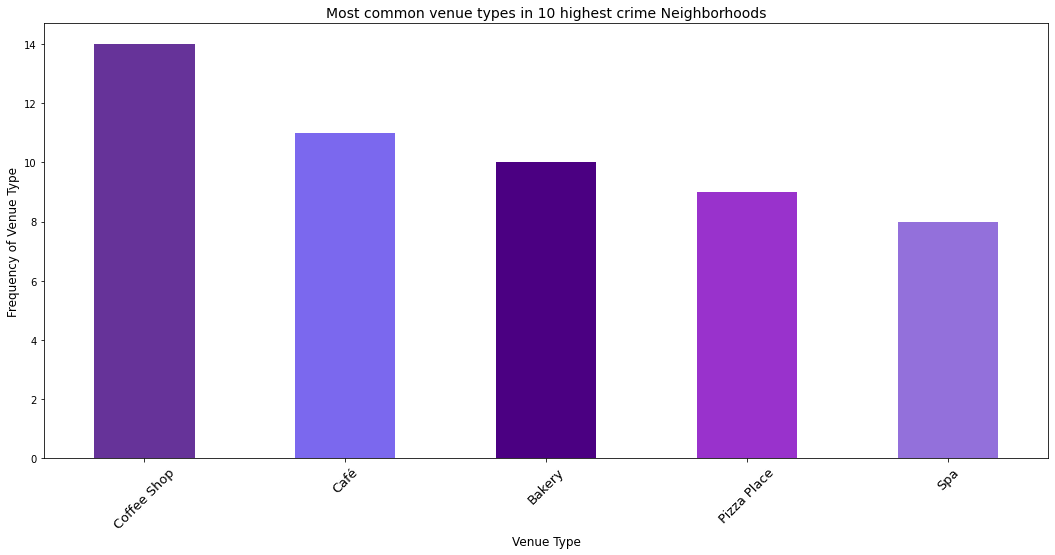

In [17]:
SF_top_venues = Venues.groupby('Venue Category', as_index = False).count().sort_values('Neighborhood', ascending = False).head(5)
SF_top_venues = SF_top_venues[['Venue Category','Neighborhood']]
SF_top_venues.rename(columns={'Neighborhood': 'Frequency'}, inplace = True)
SF_top_venues.plot.bar(x='Venue Category', y='Frequency', legend = None, title = "Most common venue types in 10 highest crime Neighborhoods", rot= 45, figsize = (18, 8), color=['rebeccapurple','mediumslateblue','indigo','darkorchid','mediumpurple'])
plt.ylabel('Frequency of Venue Type', fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel('Venue Type', fontsize=12)
plt.title('Most common venue types in 10 highest crime Neighborhoods', fontsize = 14)
plt.show()

Cofee shops are the most common venue and all in all the top 5 are made of Venues from the Food and beverage indistry.  
To be able to get more insite we need to further analyse the results. Meaning have a look at all the other venues frequencies.

In [18]:
# one hot encoding
SF_onehot = pd.get_dummies(Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SF_onehot['Neighborhood'] = Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

SF_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Bagel Shop,Bakery,Bar,...,Tiki Bar,Toy / Game Store,Trail,Trattoria/Osteria,Tuscan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Mission,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mission,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#examine shape of new dataframe
SF_onehot.shape

(289, 125)

In [20]:
#now group the data
SF_grouped = SF_onehot.groupby('Neighborhood').mean().reset_index()
print(SF_grouped.shape)
SF_grouped

(10, 125)


,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Bagel Shop,Bakery,Bar,...,Tiki Bar,Toy / Game Store,Trail,Trattoria/Osteria,Tuscan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Bayview Hunters Point,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Castro/Upper Market,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333
2,Financial District/South Beach,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
3,Mission,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
4,Nob Hill,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.033333
5,North Beach,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333
6,South of Market,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000
7,Sunset/Parkside,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,...,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Tenderloin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.000000,0.000000
9,Western Addition,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333


In [21]:

#print each neighborhood with the top 10 most common venues
num_top_venues = 10

for hood in SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = SF_grouped[SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayview Hunters Point----
                             venue  freq
0  Southern / Soul Food Restaurant  0.16
1                           Bakery  0.11
2                             Café  0.05
3                       Print Shop  0.05
4               Chinese Restaurant  0.05
5              Dumpling Restaurant  0.05
6                              Gym  0.05
7                          Theater  0.05
8           Thrift / Vintage Store  0.05
9                         Pharmacy  0.05


----Castro/Upper Market----
                     venue  freq
0         Sushi Restaurant  0.07
1                      Gym  0.07
2                  Gay Bar  0.07
3              Yoga Studio  0.03
4              Salad Place  0.03
5             Concert Hall  0.03
6             Dance Studio  0.03
7       Seafood Restaurant  0.03
8       Mexican Restaurant  0.03
9  Scandinavian Restaurant  0.03


----Financial District/South Beach----
                venue  freq
0                 Gym  0.10
1      Scenic Lookout  0.10
2

In [22]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 30

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SF_grouped['Neighborhood']

for ind in np.arange(SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
0,Bayview Hunters Point,Southern / Soul Food Restaurant,Bakery,Theater,Thrift / Vintage Store,Motorcycle Shop,Factory,Mexican Restaurant,Park,Dumpling Restaurant,...,Farmers Market,Filipino Restaurant,Yoga Studio,French Restaurant,Food Truck,Fountain,Diner,Furniture / Home Store,Garden,Gastropub
1,Castro/Upper Market,Gym,Gay Bar,Sushi Restaurant,Yoga Studio,Poke Place,Scandinavian Restaurant,Sandwich Place,Salad Place,Cocktail Bar,...,Grocery Store,Seafood Restaurant,Gym / Fitness Center,Beer Garden,Wine Bar,Bakery,Tiki Bar,Café,Electronics Store,Empanada Restaurant
2,Financial District/South Beach,Gym,Scenic Lookout,Spa,Coffee Shop,Seafood Restaurant,Steakhouse,Dim Sum Restaurant,Deli / Bodega,Cycle Studio,...,Liquor Store,Japanese Restaurant,Trail,Dumpling Restaurant,Gym / Fitness Center,Dive Shop,Donut Shop,Grocery Store,Gourmet Shop,Furniture / Home Store
3,Mission,Café,Cocktail Bar,Mexican Restaurant,Yoga Studio,Office,South American Restaurant,Climbing Gym,Coffee Shop,Deli / Bodega,...,Beer Bar,Thai Restaurant,Boxing Gym,American Restaurant,Bakery,Tech Startup,Arts & Crafts Store,Bar,Filipino Restaurant,Food Truck
4,Nob Hill,Italian Restaurant,Grocery Store,French Restaurant,Yoga Studio,Diner,Sculpture Garden,Church,Concert Hall,Convenience Store,...,Wine Bar,Breakfast Spot,American Restaurant,Boutique,Beer Bar,Bike Shop,Burrito Place,Art Museum,Filipino Restaurant,Food Truck
5,North Beach,Café,Pizza Place,Bakery,Italian Restaurant,Park,Yoga Studio,New American Restaurant,Salon / Barbershop,Restaurant,...,Trattoria/Osteria,Speakeasy,Electronics Store,Cycle Studio,Dance Studio,Design Studio,Dim Sum Restaurant,Diner,Dive Bar,Dive Shop
6,South of Market,Café,Gym / Fitness Center,Coffee Shop,Pizza Place,New American Restaurant,Museum,Roof Deck,Dive Shop,Electronics Store,...,Tea Room,Bakery,Vietnamese Restaurant,American Restaurant,Art Museum,Bubble Tea Shop,Furniture / Home Store,Farmers Market,Bar,Filipino Restaurant
7,Sunset/Parkside,Chinese Restaurant,Dumpling Restaurant,Korean Restaurant,Park,Sandwich Place,Pharmacy,Sushi Restaurant,Coffee Shop,Ice Cream Shop,...,Toy / Game Store,Japanese Restaurant,Donut Shop,Factory,Filipino Restaurant,Farmers Market,Electronics Store,Furniture / Home Store,Food Truck,Fountain
8,Tenderloin,Coffee Shop,Cocktail Bar,Wine Bar,Speakeasy,Sandwich Place,Burger Joint,Theater,Spa,Music Venue,...,Bakery,Yoga Studio,Empanada Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop,Dive Shop,Factory,Fountain,Farmers Market
9,Western Addition,Spa,Yoga Studio,Sandwich Place,Record Shop,Pizza Place,Park,Optical Shop,New American Restaurant,Music Venue,...,American Restaurant,Roller Rink,Accessories Store,Tiki Bar,Sushi Restaurant,Wine Bar,Spiritual Center,Souvlaki Shop,Theater,Shoe Repair


Now that we have a relativly detailed analysis of the venues for the top 10 neighborhoods with crime we can cluster these neighborhoods based on the price.

### Clustering



In this section we will cluster the neighborhoods into groups and see if the clustering mechanism can pick up any trends in terms of the venues in relation to the crime rates which we have obtained. 

In [24]:
# set number of clusters
kclusters = 3

SF_grouped_clustering = SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 1, 1, 2, 1, 0, 1, 1], dtype=int32)

In [28]:
# add clustering labels
# getting the percentage of crime that each neighborghood contributes to the top 10


b= crime6['Incident_type'].sum()
crime6['percent']= crime6['Incident_type']/b

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

SF_merged= crime6
SF_merged = SF_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')




SF_merged.head(10)


,Neighborhood,Incident_type,Latitude,Longitude,percent,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,...,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue
18,Mission,44423,37.7599,-122.4148,0.186003,1,Café,Cocktail Bar,Mexican Restaurant,Yoga Studio,...,Beer Bar,Thai Restaurant,Boxing Gym,American Restaurant,Bakery,Tech Startup,Arts & Crafts Store,Bar,Filipino Restaurant,Food Truck
35,Tenderloin,41121,37.7842493,-122.4139933,0.172178,1,Coffee Shop,Cocktail Bar,Wine Bar,Speakeasy,...,Bakery,Yoga Studio,Empanada Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop,Dive Shop,Factory,Fountain,Farmers Market
5,Financial District/South Beach,34398,37.7900,-122.3902,0.144028,1,Gym,Scenic Lookout,Spa,Coffee Shop,...,Liquor Store,Japanese Restaurant,Trail,Dumpling Restaurant,Gym / Fitness Center,Dive Shop,Donut Shop,Grocery Store,Gourmet Shop,Furniture / Home Store
33,South of Market,33867,37.7808925,-122.4009518,0.141804,1,Café,Gym / Fitness Center,Coffee Shop,Pizza Place,...,Tea Room,Bakery,Vietnamese Restaurant,American Restaurant,Art Museum,Bubble Tea Shop,Furniture / Home Store,Farmers Market,Bar,Filipino Restaurant
0,Bayview Hunters Point,24424,37.7304,-122.3844,0.102266,0,Southern / Soul Food Restaurant,Bakery,Theater,Thrift / Vintage Store,...,Farmers Market,Filipino Restaurant,Yoga Studio,French Restaurant,Food Truck,Fountain,Diner,Furniture / Home Store,Garden,Gastropub
40,Western Addition,13036,37.779559,-122.4298104,0.054583,1,Spa,Yoga Studio,Sandwich Place,Record Shop,...,American Restaurant,Roller Rink,Accessories Store,Tiki Bar,Sushi Restaurant,Wine Bar,Spiritual Center,Souvlaki Shop,Theater,Shoe Repair
2,Castro/Upper Market,12292,37.767115,-122.4288861,0.051468,1,Gym,Gay Bar,Sushi Restaurant,Yoga Studio,...,Grocery Store,Seafood Restaurant,Gym / Fitness Center,Beer Garden,Wine Bar,Bakery,Tiki Bar,Café,Electronics Store,Empanada Restaurant
22,North Beach,11922,37.8011749,-122.4090021,0.049919,2,Café,Pizza Place,Bakery,Italian Restaurant,...,Trattoria/Osteria,Speakeasy,Electronics Store,Cycle Studio,Dance Studio,Design Studio,Dim Sum Restaurant,Diner,Dive Bar,Dive Shop
34,Sunset/Parkside,11805,37.7425,-122.4896,0.049429,0,Chinese Restaurant,Dumpling Restaurant,Korean Restaurant,Park,...,Toy / Game Store,Japanese Restaurant,Donut Shop,Factory,Filipino Restaurant,Farmers Market,Electronics Store,Furniture / Home Store,Food Truck,Fountain
20,Nob Hill,11541,37.7930,-122.4161,0.048323,1,Italian Restaurant,Grocery Store,French Restaurant,Yoga Studio,...,Wine Bar,Breakfast Spot,American Restaurant,Boutique,Beer Bar,Bike Shop,Burrito Place,Art Museum,Filipino Restaurant,Food Truck


### Visualize Clusters on Map

We initialize the map using the Lat and Long coordinates of San Fransisco


In [26]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="SF_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.4199061.


In [30]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
folium.TileLayer('cartodbdark_matter').add_to(map_clusters)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(.7, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
markers_colors = []
for lat, lon, poi, cluster, bars in zip(SF_merged['Latitude'], SF_merged['Longitude'], SF_merged['Neighborhood'], SF_merged['Cluster Labels'], SF_merged['percent']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=35*bars,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## Results and Discussion
From the clusters obtained of the top 10 neighberhoods with crime in San Fransisco, we were able to make some deductions on the crime data as well as the data on the different venues in the neighborhoods. Out of the top 10 neighborhoods for crime from our dataset, 7 of them were placed into cluster number 1. Of these 7 neigberhoods 5 of which were in the top 5 neighborhoods for crime incidents in San Fransisco. On the other hand, cluster 0 and 2 contained 2 of the bottom 3 neighberhoods when it comes to crime from the dataset. Further inspecting the aggregated data which contains the top 30 venues in each area of San Fransisco we can gather some more insites on the data. First, for Financial district, castro and south of market gyms/fitness centers were present in the top 5 venues in those area. These 3 neighborhoods did rank highly on the crime ranking but were not towards the top. Interestingly, the two run aways for the top neighberhoods for crime had a similar distribution of venues in the top 5. This included cafes and bar with the highest rated health and fitness place ranking 23rd for mission. Perhaps this is a contributing factor to the crime in an area, the amount of places there are to expend energy and excersise. 

Other ways that these insights can be helpful is for anyone looking to start up a new business in these neighborhoods. From the data, new owners would do well to avoid most of the neighborhoods in cluster 1 as these are mostly made up of the top crime neighborhoods in the area. Anyone looking to open a business weather that be a restaurant, school or bar would want there customers to feel safe especially when there are children inolved. Additionally, the list for the top 30 most common businesses in each venue can help new investors identify any market gaps they may want to fill. Haviing a look at the less common businesses found in the neighborhoods can give new owners a competitive advantage in an area with very little competition.


## Conclusion
We were able to use the various tools for an end to end data science project. These included the foursquare api to fetch data on the different venues as well as mining different datasets to obtain interesting data for our research. 